In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F


import warnings
warnings.filterwarnings('ignore')

Train PubMed

In [2]:
import import_ipynb
import pubmed_gnn

importing Jupyter notebook from pubmed_gnn.ipynb
HeteroData(
  disease={
    x=[454, 200],
    y=[454],
    train_mask=[454],
    val_mask=[454],
    test_mask=[454]
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)
Epoch: 010, Loss: 0.9841, Train: 0.6887, Val: 0.5441, Test: 0.4412
Epoch: 020, Loss: 0.2349, Train: 0.9245, Val: 0.4706, Test: 0.4559
Epoch: 030, Loss: 0.0334, Train: 0.9969, Val: 0.5588, Test: 0.4706
Epoch: 040, Loss: 0.0047, Train: 1.0000, Val: 0.5441, Test: 0.4853
Epoch: 050, Loss: 0.0018, Train: 1.0000, Val: 0.5441, Test: 0.4853
Epoch: 060, Loss: 0.0024, Train: 1.0000, Val: 0.5441, Test: 0.4559
Epoch: 070, Loss: 0.0043, Train: 1.0000, Val: 0.5441, Tes

In [3]:
model = pubmed_gnn.model

Graph (without node features) generated from HGEN

In [4]:
G = nx.read_gexf("PubMed_hgen.gexf")

Adding node features to graph

importing Jupyter notebook from pubmed_gmm_features.ipynb
no of class disease0 node samples - 80
no of class disease1 node samples - 80
no of class disease2 node samples - 80
no of class disease3 node samples - 80
no of class disease4 node samples - 80
no of class disease5 node samples - 81
no of class disease6 node samples - 81
no of class disease7 node samples - 81
no of class gene node samples - 313
no of class chemical node samples - 564
no of class species node samples - 45


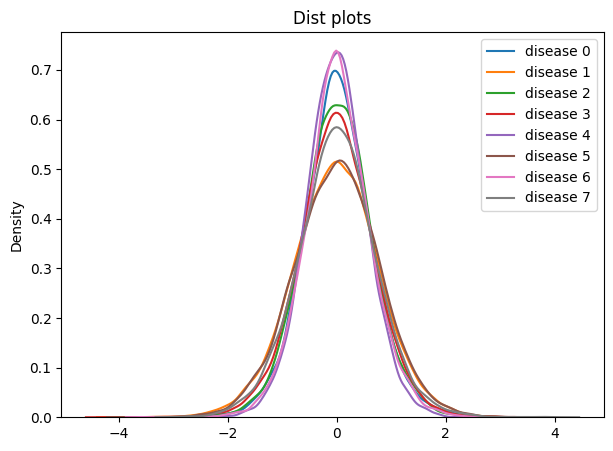

In [5]:
#Load node features 

import pubmed_gmm_features

In [6]:
disease_node_features = pubmed_gmm_features.disease_node_features
gene_node_features = pubmed_gmm_features.gene_node_features
chemical_node_features = pubmed_gmm_features.chemical_node_features
species_node_features = pubmed_gmm_features.species_node_features

In [7]:
 #Adding node degree
for node in G.nodes():
    d = G.degree(node)
    G.nodes[node]["degree"] = d

In [8]:
#Generate graphs of 2-hop neighbourhood
def graph_gen(nodeid):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    if 3 <= len(nodes) <= 80:
        graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
        #Get small graph edges
        edges = [e for e in graph.edges]
        #nx.draw(graph, with_labels = True)
        #plt.show()
        #print('nodeid',nodeid)
        #print('node count',len(nodes))
        #print('edge count',len(edges))
        return nodes, edges
    else:
        return None, None

In [9]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [10]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [11]:
all_edges = {}

In [12]:
def create_dataset(nodes,edges,disease_node_features,gene_node_features,chemical_node_features,
                   species_node_features,node_id):
    
    disease_df = disease_node_features[disease_node_features["nodeId"].isin([int(x) for x in nodes])]
    gene_df = gene_node_features[gene_node_features["nodeId"].isin([int(x) for x in nodes])]
    chemical_df = chemical_node_features[chemical_node_features["nodeId"].isin([int(x) for x in nodes])]
    species_df = species_node_features[species_node_features["nodeId"].isin([int(x) for x in nodes])] 
    
    #Nodes   
    disease = np.asarray(disease_df.drop(columns=['nodeId','class']))
    gene = np.asarray(gene_df.drop(columns=['nodeId']))
    chemical = np.asarray(chemical_df.drop(columns=['nodeId']))
    species = np.asarray(species_df.drop(columns=['nodeId']))
    
    x_disease = torch.tensor(disease).to(dtype=torch.float32)
    y_disease = torch.tensor(np.array(disease_df["class"]), dtype=torch.long)
    x_gene = torch.tensor(gene).to(dtype=torch.float32)
    x_chemical = torch.tensor(chemical).to(dtype=torch.float32)
    x_species = torch.tensor(species).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))
    
    gene_to_gene = []
    gene_to_disease = []
    disease_to_disease = []
    chemical_to_gene = []
    chemical_to_disease = []
    chemical_to_chemical = []
    chemical_to_species = []
    species_to_gene = []
    species_to_disease = []
    species_to_species = []
    remaining_edges = []
    for i in range(len(edges)):


        if (int(source[i]) in list(gene_df['nodeId'])) and (int(dest[i]) in list(gene_df['nodeId'])):
                gene_to_gene.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(gene_df['nodeId'])) and (int(dest[i]) in list(disease_df['nodeId'])):
                gene_to_disease.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(disease_df['nodeId'])) and (int(dest[i]) in list(disease_df['nodeId'])):
                disease_to_disease.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(gene_df['nodeId'])):
                chemical_to_gene.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(disease_df['nodeId'])):
                chemical_to_disease.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(chemical_df['nodeId'])):
                chemical_to_chemical.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(species_df['nodeId'])):
                chemical_to_species.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(species_df['nodeId'])) and (int(dest[i]) in list(gene_df['nodeId'])):
                species_to_gene.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(species_df['nodeId'])) and (int(dest[i]) in list(disease_df['nodeId'])):
                species_to_disease.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(species_df['nodeId'])) and (int(dest[i]) in list(species_df['nodeId'])):
                species_to_species.append((int(source[i]),int(dest[i])))
        else:
            remaining_edges.append((int(source[i]),int(dest[i])))
    
    all_edges[node_id] = [*gene_to_gene,*gene_to_disease,*disease_to_disease,*chemical_to_gene,
                          *chemical_to_disease,*chemical_to_chemical,*chemical_to_species, *species_to_gene, 
                          *species_to_disease, *species_to_species]
               
    #Re-map indices to correct range
    disease_nodes_mapping = remap_indices(list(disease_df["nodeId"]))
    gene_nodes_mapping = remap_indices(list(gene_df["nodeId"]))
    chemical_nodes_mapping = remap_indices(list(chemical_df["nodeId"]))
    species_nodes_mapping = remap_indices(list(species_df["nodeId"]))
    
    node_list = {}
    for d in [disease_nodes_mapping, gene_nodes_mapping, chemical_nodes_mapping,species_nodes_mapping]:
        node_list.update(d)
    
    #Create Hetero Data      
    small_graph = HeteroData({'disease':{'x': x_disease, 'y':y_disease}, 'gene':{'x': x_gene},
                              'chemical':{'x': x_chemical}, 'species':{'x': x_species}})

        
    if gene_to_gene:
        edge_index_gene_gene = preprocess_edges(gene_to_gene,node_list)
        small_graph['gene','to','gene'].edge_index = edge_index_gene_gene
    if gene_to_disease:
        edge_index_gene_disease = preprocess_edges(gene_to_disease,node_list)
        small_graph['gene','to','disease'].edge_index = edge_index_gene_disease
    if disease_to_disease:
        edge_index_disease_disease = preprocess_edges(disease_to_disease,node_list)
        small_graph['disease','to','disease'].edge_index = edge_index_disease_disease
    if chemical_to_gene:
        edge_index_chemical_gene = preprocess_edges(chemical_to_gene,node_list)
        small_graph['chemical','to','gene'].edge_index = edge_index_chemical_gene
    if chemical_to_disease:
        edge_index_chemical_disease = preprocess_edges(chemical_to_disease,node_list)
        small_graph['chemical','to','disease'].edge_index = edge_index_chemical_disease
    if chemical_to_chemical:
        edge_index_chemical_chemical = preprocess_edges(chemical_to_chemical,node_list)
        small_graph['chemical','to','chemical'].edge_index = edge_index_chemical_chemical
    if chemical_to_species:
        edge_index_chemical_species = preprocess_edges(chemical_to_species,node_list)
        small_graph['chemical','to','species'].edge_index = edge_index_chemical_species
    if species_to_gene:
        edge_index_species_gene = preprocess_edges(species_to_gene,node_list)
        small_graph['species','to','gene'].edge_index = edge_index_species_gene
    if species_to_disease:
        edge_index_species_disease = preprocess_edges(species_to_disease,node_list)
        small_graph['species','to','disease'].edge_index = edge_index_species_disease
    if species_to_species:
        edge_index_species_species = preprocess_edges(species_to_species,node_list)
        small_graph['species','to','species'].edge_index = edge_index_species_species
        

    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
    
    return small_graph

In [13]:
def evaluate_gnn(small_graph):
    
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['disease'].test_mask
        correct = (pred[mask] == small_graph['disease'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['disease'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [37]:
node_subset = dict((n,d['degree']) for n,d in G.nodes().items() if d['degree']>=2)
n_list= random.sample(node_subset.keys(), 1200)

In [38]:
softmax_dict = {}
nodefeature_dict = {}
for nodeid in n_list: 
    #Generate small Graphs
    nodes, edges = graph_gen(nodeid)
    if not (nodes is None):

        
            small_graph_data = create_dataset(nodes,edges,
                                  disease_node_features,gene_node_features,
                                  chemical_node_features,species_node_features,nodeid)
            

            edge_list = all_edges[nodeid]
            graph = nx.Graph(edge_list)
            if nx.is_connected(graph):

                if (small_graph_data['disease'].x.nelement()!=0) and \
                (small_graph_data['gene','to','gene']) and \
                (small_graph_data['chemical','to','gene']) and \
                (small_graph_data['chemical','to','disease']) and \
                (small_graph_data['gene','to','disease']) and \
                (small_graph_data['chemical','to','species']):


                    print('nodeid',nodeid)
                    print('node count',small_graph_data.num_nodes)
                    print('edge count',small_graph_data.num_edges)

                    #graph = nx.ego_graph(G,nodeid, 2, center=True,undirected = True)
                    #nx.draw(graph, with_labels = True)
                    #plt.show() 

                    #Evaluate trained PubMed on smaller graphs

                    softmax,correct_indices  = evaluate_gnn(small_graph_data)
                    softmax_dict[nodeid] = softmax
                    nodefeature_dict[nodeid]={'gene':small_graph_data['gene'].x,
                                         'disease':small_graph_data['disease'].x[correct_indices],
                                         'chemical':small_graph_data['chemical'].x,
                                          'species':small_graph_data['species'].x}
                    #print(small_graph_data)

                else:
                    #print("The next graph could not be evaluated. Required edges are missing.")
                    pass

            else:
                #print("The next graph could not be loaded. Node count is less than 3")
                pass


nodeid 1564
node count 55
edge count 65
HeteroData(
  disease={
    x=[13, 200],
    y=[13],
    train_mask=[13],
    val_mask=[13],
    test_mask=[13]
  },
  gene={ x=[13, 200] },
  chemical={ x=[27, 200] },
  species={ x=[2, 200] },
  (gene, to, gene)={ edge_index=[2, 3] },
  (gene, to, disease)={ edge_index=[2, 5] },
  (disease, to, disease)={ edge_index=[2, 2] },
  (chemical, to, gene)={ edge_index=[2, 11] },
  (chemical, to, disease)={ edge_index=[2, 16] },
  (chemical, to, chemical)={ edge_index=[2, 22] },
  (chemical, to, species)={ edge_index=[2, 4] },
  (species, to, gene)={ edge_index=[2, 1] },
  (species, to, disease)={ edge_index=[2, 1] }
)
Prediction: tensor([6, 2, 1, 7, 3, 5, 5, 4, 5, 3, 6, 6, 7])
Ground Truth: tensor([2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 6, 7, 7])
tensor([False,  True, False, False,  True, False, False,  True, False, False,
         True, False,  True])
tensor([[2.1109e-04, 3.2865e-18, 2.9148e-17, 8.8954e-20, 1.7703e-08, 2.7833e-12,
         9.9978e-01, 4.8570e

nodeid 1233
node count 52
edge count 66
HeteroData(
  disease={
    x=[8, 200],
    y=[8],
    train_mask=[8],
    val_mask=[8],
    test_mask=[8]
  },
  gene={ x=[10, 200] },
  chemical={ x=[33, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 3] },
  (gene, to, disease)={ edge_index=[2, 6] },
  (disease, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 10] },
  (chemical, to, disease)={ edge_index=[2, 10] },
  (chemical, to, chemical)={ edge_index=[2, 35] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 5, 2, 2, 1, 1, 5, 0])
Ground Truth: tensor([1, 1, 2, 2, 3, 4, 4, 6])
tensor([ True, False,  True,  True, False, False, False, False])
tensor([[1.8762e-22, 1.0000e+00, 1.5374e-37, 3.1009e-22, 1.2282e-19, 3.0114e-09,
         0.0000e+00, 5.0327e-35],
        [1.4718e-20, 3.2274e-11, 4.2039e-45, 2.0266e-22, 9.8577e-26, 1.0000e+00,
         1.1627e-41, 6.3558e-20],
        [1.4425e-16, 3.8992e-17, 1.0000e+00, 1.044

nodeid 746
node count 63
edge count 71
HeteroData(
  disease={
    x=[16, 200],
    y=[16],
    train_mask=[16],
    val_mask=[16],
    test_mask=[16]
  },
  gene={ x=[17, 200] },
  chemical={ x=[29, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 7] },
  (gene, to, disease)={ edge_index=[2, 8] },
  (disease, to, disease)={ edge_index=[2, 8] },
  (chemical, to, gene)={ edge_index=[2, 22] },
  (chemical, to, disease)={ edge_index=[2, 11] },
  (chemical, to, chemical)={ edge_index=[2, 14] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 0, 1, 1, 0, 7, 2, 1, 5, 3, 4, 4, 5, 5, 3, 6])
Ground Truth: tensor([0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
tensor([ True,  True, False,  True, False, False,  True, False, False,  True,
         True,  True,  True,  True, False,  True])
tensor([[1.0000e+00, 9.9789e-13, 4.3604e-14, 3.1510e-22, 4.6431e-09, 1.0659e-18,
         2.5013e-11, 2.4881e-18],
        [1.0000e+00, 3.5103e-11, 3.0549e-07, 3.97

nodeid 1399
node count 64
edge count 70
HeteroData(
  disease={
    x=[25, 200],
    y=[25],
    train_mask=[25],
    val_mask=[25],
    test_mask=[25]
  },
  gene={ x=[12, 200] },
  chemical={ x=[26, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 3] },
  (gene, to, disease)={ edge_index=[2, 15] },
  (disease, to, disease)={ edge_index=[2, 5] },
  (chemical, to, gene)={ edge_index=[2, 6] },
  (chemical, to, disease)={ edge_index=[2, 16] },
  (chemical, to, chemical)={ edge_index=[2, 24] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 0, 5, 1, 1, 2, 1, 2, 2, 2, 2, 2, 5, 6, 1, 4, 5, 5, 6, 7, 5, 0, 3, 2,
        7])
Ground Truth: tensor([0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7,
        7])
tensor([False,  True, False,  True,  True,  True, False,  True,  True,  True,
         True, False, False, False, False,  True,  True,  True,  True, False,
        False, False, False, False,  True])
tensor([[2.0882e-02, 9

nodeid 1119
node count 69
edge count 77
HeteroData(
  disease={
    x=[19, 200],
    y=[19],
    train_mask=[19],
    val_mask=[19],
    test_mask=[19]
  },
  gene={ x=[21, 200] },
  chemical={ x=[28, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 10] },
  (gene, to, disease)={ edge_index=[2, 11] },
  (disease, to, disease)={ edge_index=[2, 6] },
  (chemical, to, gene)={ edge_index=[2, 11] },
  (chemical, to, disease)={ edge_index=[2, 17] },
  (chemical, to, chemical)={ edge_index=[2, 21] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 1, 5, 2, 2, 2, 6, 2, 1, 4, 4, 4, 3, 6, 1, 5, 7, 7, 7])
Ground Truth: tensor([0, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 7, 7, 7])
tensor([ True,  True, False,  True,  True,  True, False,  True, False,  True,
         True,  True, False,  True, False, False,  True,  True,  True])
tensor([[1.0000e+00, 1.3799e-10, 4.4971e-08, 3.4860e-15, 1.6005e-15, 3.5050e-19,
         3.6254e-17, 5.9480e-24],
       

nodeid 1432
node count 58
edge count 66
HeteroData(
  disease={
    x=[22, 200],
    y=[22],
    train_mask=[22],
    val_mask=[22],
    test_mask=[22]
  },
  gene={ x=[12, 200] },
  chemical={ x=[23, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 1] },
  (gene, to, disease)={ edge_index=[2, 8] },
  (disease, to, disease)={ edge_index=[2, 9] },
  (chemical, to, gene)={ edge_index=[2, 7] },
  (chemical, to, disease)={ edge_index=[2, 21] },
  (chemical, to, chemical)={ edge_index=[2, 19] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 0, 3, 1, 1, 2, 2, 5, 2, 3, 5, 4, 5, 3, 3, 1, 5, 6, 1, 5, 5, 1])
Ground Truth: tensor([0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7])
tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True, False, False, False, False,  True, False, False,
        False, False])
tensor([[1.0000e+00, 1.0619e-10, 4.2267e-18, 7.2427e-20, 1.2473e-15, 1.1749e-1

nodeid 35
node count 33
edge count 35
HeteroData(
  disease={
    x=[2, 200],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  gene={ x=[11, 200] },
  chemical={ x=[18, 200] },
  species={ x=[2, 200] },
  (gene, to, gene)={ edge_index=[2, 9] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 16] },
  (chemical, to, disease)={ edge_index=[2, 1] },
  (chemical, to, chemical)={ edge_index=[2, 6] },
  (chemical, to, species)={ edge_index=[2, 1] },
  (species, to, gene)={ edge_index=[2, 1] }
)
Prediction: tensor([5, 6])
Ground Truth: tensor([0, 2])
tensor([False, False])
tensor([[1.9676e-14, 5.5728e-05, 2.9401e-16, 8.7605e-05, 2.8737e-09, 9.9986e-01,
         4.4703e-18, 4.4543e-08],
        [2.1109e-04, 3.2865e-18, 2.9148e-17, 8.8954e-20, 1.7703e-08, 2.7833e-12,
         9.9978e-01, 4.8570e-06]])
correct indices []
------------------------------------------------------------------
nodeid 588
node count 60
edge count 76
HeteroDat

nodeid 148
node count 66
edge count 82
HeteroData(
  disease={
    x=[12, 200],
    y=[12],
    train_mask=[12],
    val_mask=[12],
    test_mask=[12]
  },
  gene={ x=[11, 200] },
  chemical={ x=[42, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 2] },
  (gene, to, disease)={ edge_index=[2, 5] },
  (disease, to, disease)={ edge_index=[2, 3] },
  (chemical, to, gene)={ edge_index=[2, 13] },
  (chemical, to, disease)={ edge_index=[2, 19] },
  (chemical, to, chemical)={ edge_index=[2, 39] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 5, 5, 1, 5, 1, 2, 4, 3, 5, 1, 7])
Ground Truth: tensor([0, 0, 0, 1, 1, 2, 2, 4, 5, 5, 5, 7])
tensor([False, False, False,  True, False, False,  True,  True, False,  True,
        False,  True])
tensor([[2.0882e-02, 9.7912e-01, 2.1162e-11, 8.5531e-15, 1.1038e-09, 3.4368e-14,
         1.3571e-24, 1.5776e-25],
        [1.5607e-19, 6.2623e-14, 1.0156e-27, 4.5123e-10, 6.3167e-20, 1.0000e+00,
         5.1037e-24,

nodeid 108
node count 52
edge count 59
HeteroData(
  disease={
    x=[13, 200],
    y=[13],
    train_mask=[13],
    val_mask=[13],
    test_mask=[13]
  },
  gene={ x=[11, 200] },
  chemical={ x=[27, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 5] },
  (gene, to, disease)={ edge_index=[2, 7] },
  (disease, to, disease)={ edge_index=[2, 7] },
  (chemical, to, gene)={ edge_index=[2, 9] },
  (chemical, to, disease)={ edge_index=[2, 8] },
  (chemical, to, chemical)={ edge_index=[2, 22] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 1, 5, 3, 2, 3, 1, 3, 4, 2, 0, 0, 0])
Ground Truth: tensor([0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6])
tensor([ True, False, False, False,  True,  True, False, False,  True, False,
        False, False, False])
tensor([[1.0000e+00, 8.1397e-20, 6.5362e-12, 2.6613e-30, 4.6289e-18, 3.4748e-36,
         2.5745e-20, 4.8839e-37],
        [2.3015e-06, 1.0000e+00, 4.2033e-12, 3.0165e-09, 3.2868e-13, 2.5813e-09,
         

nodeid 1391
node count 42
edge count 41
HeteroData(
  disease={
    x=[17, 200],
    y=[17],
    train_mask=[17],
    val_mask=[17],
    test_mask=[17]
  },
  gene={ x=[9, 200] },
  chemical={ x=[15, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 2] },
  (gene, to, disease)={ edge_index=[2, 3] },
  (disease, to, disease)={ edge_index=[2, 7] },
  (chemical, to, gene)={ edge_index=[2, 9] },
  (chemical, to, disease)={ edge_index=[2, 9] },
  (chemical, to, chemical)={ edge_index=[2, 10] },
  (chemical, to, species)={ edge_index=[2, 1] }
)
Prediction: tensor([3, 0, 3, 1, 2, 5, 3, 5, 3, 4, 4, 3, 3, 6, 1, 7, 7])
Ground Truth: tensor([0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 6, 6, 7, 7, 7])
tensor([False,  True, False,  True,  True, False,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True])
tensor([[7.8511e-06, 1.8609e-06, 2.7649e-06, 9.9686e-01, 1.4092e-11, 3.1277e-03,
         2.9543e-10, 9.9095e-08],
        [1.0000e+00, 1.2509e-26, 6.087

HeteroData(
  disease={
    x=[11, 200],
    y=[11],
    train_mask=[11],
    val_mask=[11],
    test_mask=[11]
  },
  gene={ x=[9, 200] },
  chemical={ x=[17, 200] },
  species={ x=[1, 200] },
  (gene, to, gene)={ edge_index=[2, 1] },
  (gene, to, disease)={ edge_index=[2, 4] },
  (disease, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 9] },
  (chemical, to, disease)={ edge_index=[2, 8] },
  (chemical, to, chemical)={ edge_index=[2, 16] },
  (chemical, to, species)={ edge_index=[2, 2] }
)
Prediction: tensor([0, 0, 3, 2, 7, 7, 3, 4, 4, 1, 5])
Ground Truth: tensor([0, 0, 1, 2, 2, 3, 3, 4, 4, 5, 6])
tensor([ True,  True, False,  True, False, False,  True,  True,  True, False,
        False])
tensor([[9.9887e-01, 9.7413e-04, 1.5148e-04, 2.3963e-09, 1.1964e-06, 2.3468e-11,
         4.2726e-11, 2.0608e-14],
        [9.9891e-01, 7.6647e-05, 1.0123e-03, 6.6347e-08, 5.4301e-14, 6.5662e-15,
         8.4105e-19, 3.1109e-23],
        [6.1431e-23, 4.0483e-09, 2.8431e-

In [39]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  39


In [40]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
prob_class4_dict = {}
prob_class5_dict = {}
prob_class6_dict = {}
prob_class7_dict = {}
for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []
        list4= []
        list5= []
        list6= []
        list7= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])
            list4.append(prob[4])
            list5.append(prob[5])
            list6.append(prob[6])
            list7.append(prob[7])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:
        prob_class3_dict[nodeid]=max(list3)
    if len(list4) != 0:
        prob_class4_dict[nodeid]=max(list4)
    if len(list5) != 0:
        prob_class5_dict[nodeid]=max(list5)
    if len(list6) != 0:
        prob_class6_dict[nodeid]=max(list6)
    if len(list7) != 0:
        prob_class7_dict[nodeid]=max(list7)

Getting the highest prediction probability for each class of author node

In [41]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())
max_pred4 = max(prob_class4_dict.values())
max_pred5 = max(prob_class5_dict.values())
max_pred6 = max(prob_class6_dict.values())
max_pred7 = max(prob_class7_dict.values())

In [42]:
# Getting nodeid to re-generate 2 hop graph which maximizes prediction
class0_nodeid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_nodeid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_nodeid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_nodeid = max(prob_class3_dict, key=prob_class3_dict.get)
class4_nodeid = max(prob_class4_dict, key=prob_class4_dict.get)
class5_nodeid = max(prob_class5_dict, key=prob_class5_dict.get)
class6_nodeid = max(prob_class6_dict, key=prob_class6_dict.get)
class7_nodeid = max(prob_class7_dict, key=prob_class7_dict.get)

In [43]:
print(class0_nodeid)
print(class1_nodeid)
print(class2_nodeid)
print(class3_nodeid)
print(class4_nodeid)
print(class5_nodeid)
print(class6_nodeid)
print(class7_nodeid)

1138
85
11
11
1355
11
1564
1564


In [44]:
def plot_graph(nodeid, max_pred,nodetype,edges):

    classes = []
    graph = nx.Graph(edges)
    for g in graph.nodes():
        if g in list(gene_node_features['nodeId']):
            classes.append(0)
        elif g in list(disease_node_features['nodeId']):
            classes.append(1)
        elif g in list(chemical_node_features['nodeId']):
            classes.append(2)
        elif g in list(species_node_features['nodeId']):
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), classes)), 'class')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('nodeid for generating 2 hop graph: ',nodeid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in graph.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

Plotting explanation graph with node features for each class of Disease node

Node colors:

Gene - Blue

Disease - Red

Chemical - Darkgreen

Species - Orange

In [45]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [46]:
import seaborn as sns
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

Number of nodes:  43
nodeid for generating 2 hop graph:  1138
Max pred probability for class 0 is 1.0


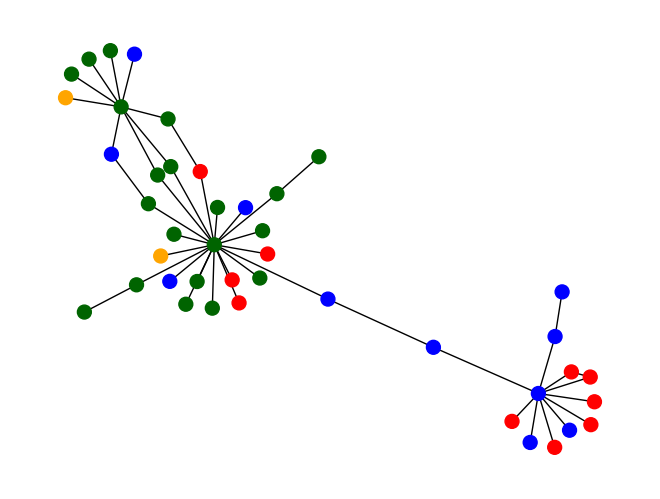

In [50]:
explanation_graph0 = plot_graph(class0_nodeid, max_pred0, 0, all_edges[class0_nodeid])

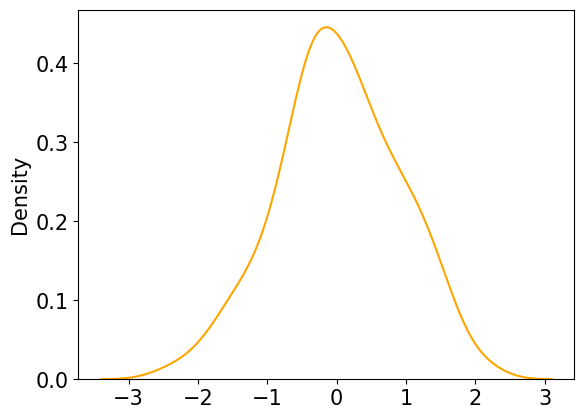

In [49]:
ind = index_2d(softmax_dict[class0_nodeid], max_pred0)[0]
disease0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease0_df)

Number of nodes:  32
nodeid for generating 2 hop graph:  85
Max pred probability for class 1 is 1.0


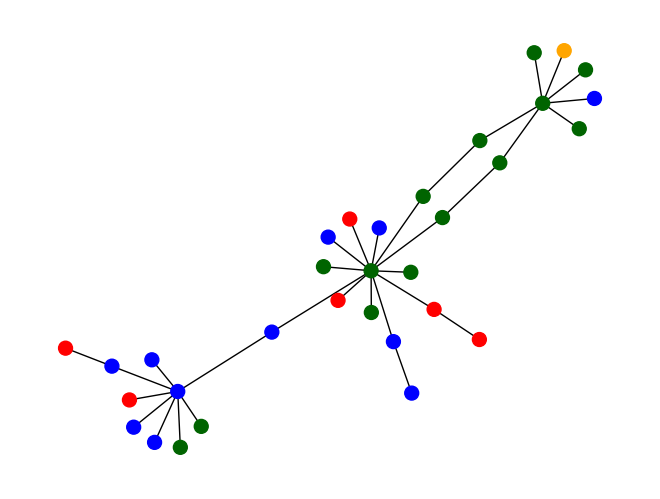

In [51]:
explanation_graph1 = plot_graph(class1_nodeid, max_pred1, 1, all_edges[class1_nodeid])

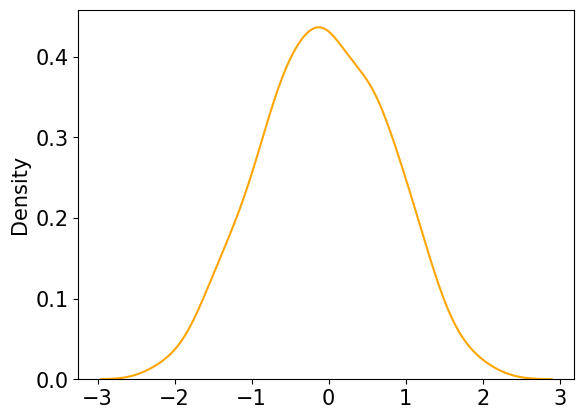

In [52]:
ind = index_2d(softmax_dict[class1_nodeid], max_pred1)[0]
disease1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease1_df)

Number of nodes:  39
nodeid for generating 2 hop graph:  11
Max pred probability for class 2 is 1.0


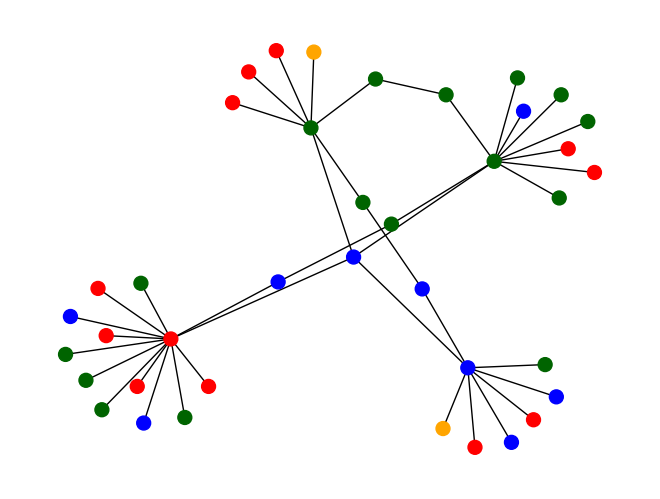

In [53]:
explanation_graph2 = plot_graph(class2_nodeid, max_pred2, 2, all_edges[class2_nodeid])

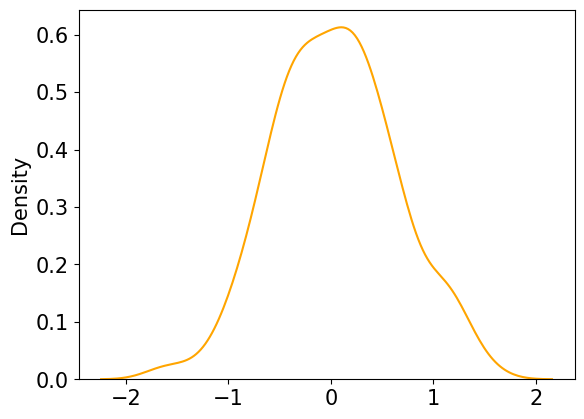

In [54]:
ind = index_2d(softmax_dict[class2_nodeid], max_pred2)[0]
disease2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease2_df)

Number of nodes:  39
nodeid for generating 2 hop graph:  11
Max pred probability for class 3 is 1.0


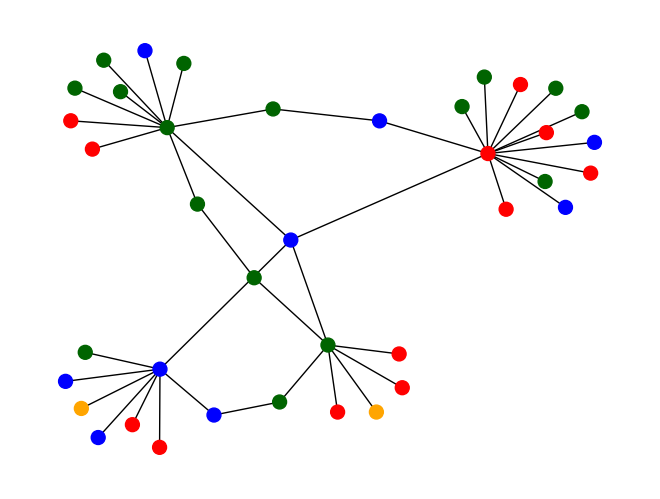

In [55]:
explanation_graph3 = plot_graph(class3_nodeid, max_pred3, 3, all_edges[class3_nodeid])

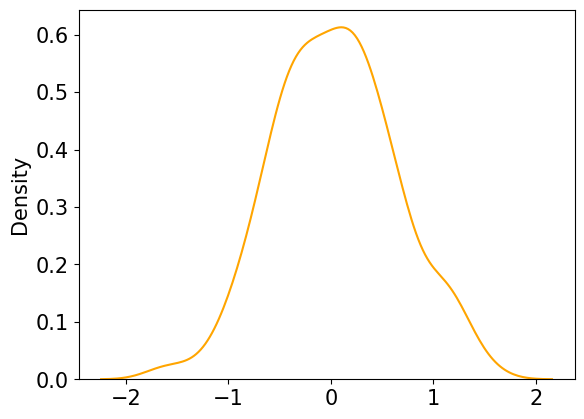

In [56]:
ind = index_2d(softmax_dict[class3_nodeid], max_pred3)[0]
disease3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease3_df)

Number of nodes:  28
nodeid for generating 2 hop graph:  1355
Max pred probability for class 4 is 1.0


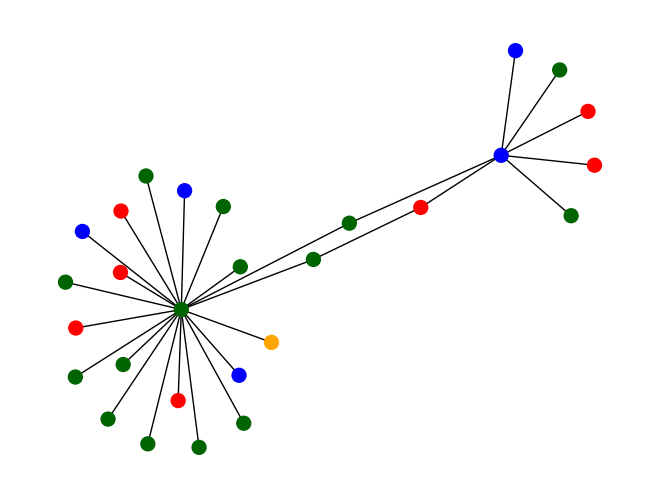

In [57]:
explanation_graph4 = plot_graph(class4_nodeid, max_pred4, 4, all_edges[class4_nodeid])

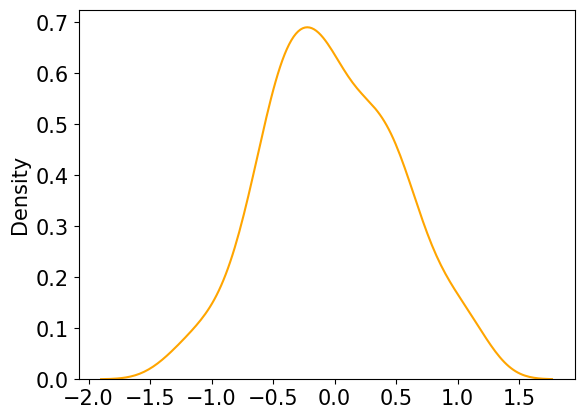

In [58]:
ind = index_2d(softmax_dict[class4_nodeid], max_pred4)[0]
disease4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease4_df)

Number of nodes:  39
nodeid for generating 2 hop graph:  11
Max pred probability for class 5 is 1.0


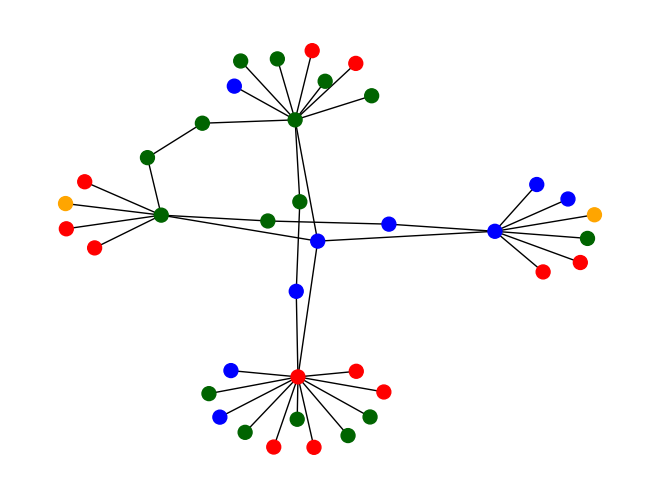

In [59]:
explanation_graph5 = plot_graph(class5_nodeid, max_pred5, 5, all_edges[class5_nodeid])

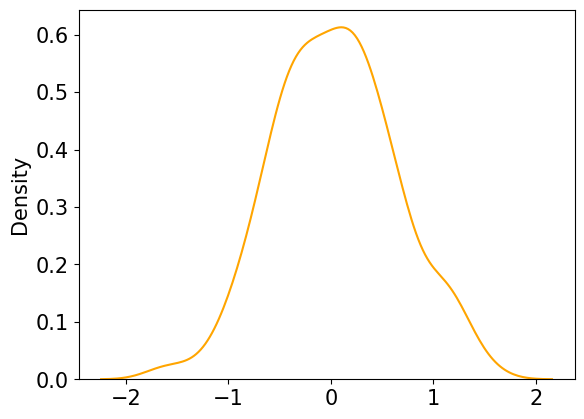

In [60]:
ind = index_2d(softmax_dict[class5_nodeid], max_pred5)[0]
disease5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease5_df)

Number of nodes:  55
nodeid for generating 2 hop graph:  1564
Max pred probability for class 6 is 1.0


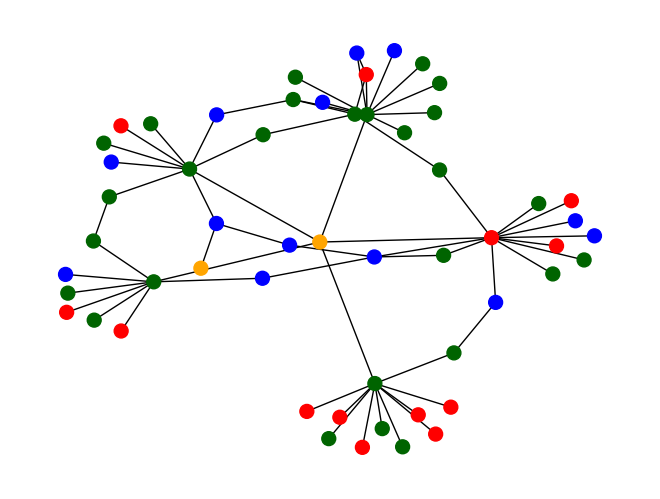

In [61]:
explanation_graph6 = plot_graph(class6_nodeid, max_pred6, 6, all_edges[class6_nodeid])

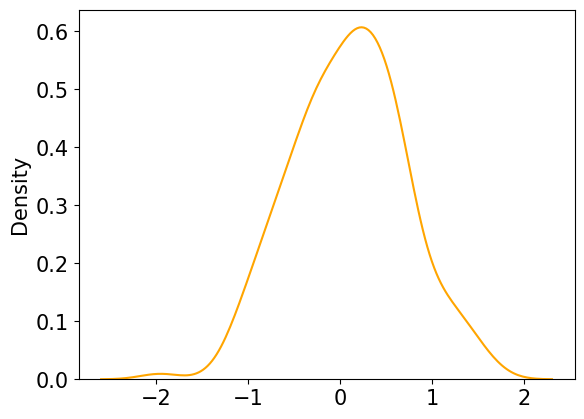

In [62]:
ind = index_2d(softmax_dict[class6_nodeid], max_pred6)[0]
disease6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease6_df)

Number of nodes:  55
nodeid for generating 2 hop graph:  1564
Max pred probability for class 7 is 1.0


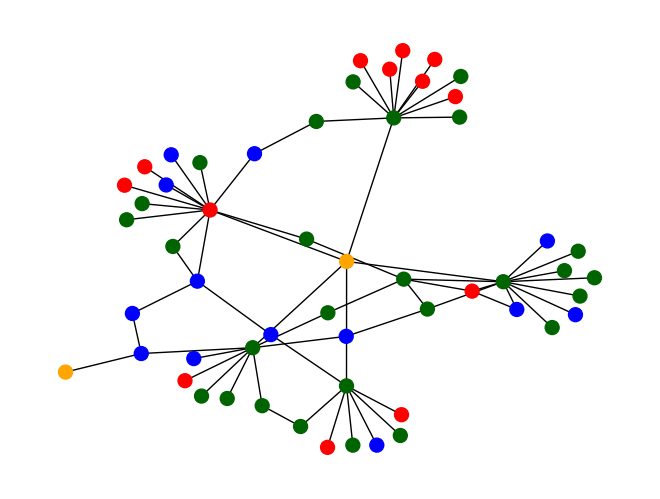

In [68]:
explanation_graph7 = plot_graph(class7_nodeid, max_pred7, 7, all_edges[class7_nodeid])

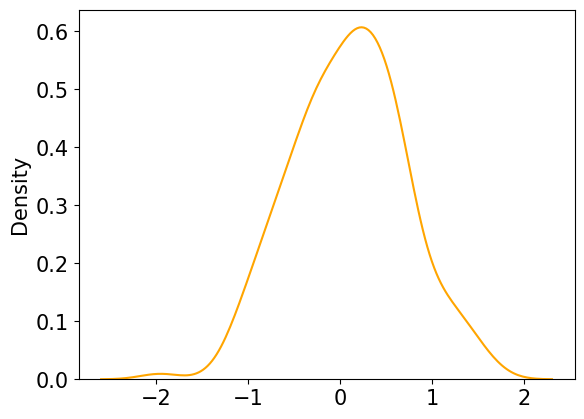

In [67]:
ind = index_2d(softmax_dict[class7_nodeid], max_pred7)[0]
disease7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease7_df)

In [ ]:
#Node features

In [ ]:
#Gene

In [69]:
gene0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['gene'].numpy())

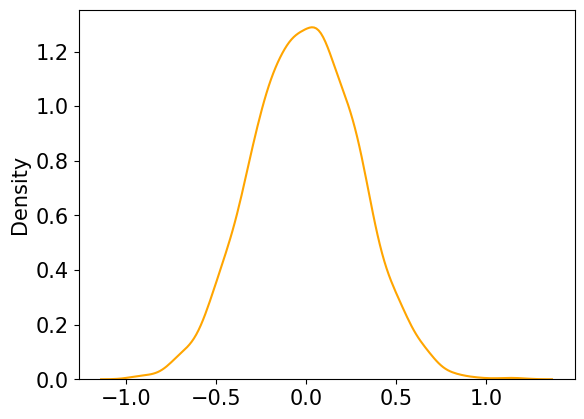

In [70]:
plot_node_feat(gene0_df)

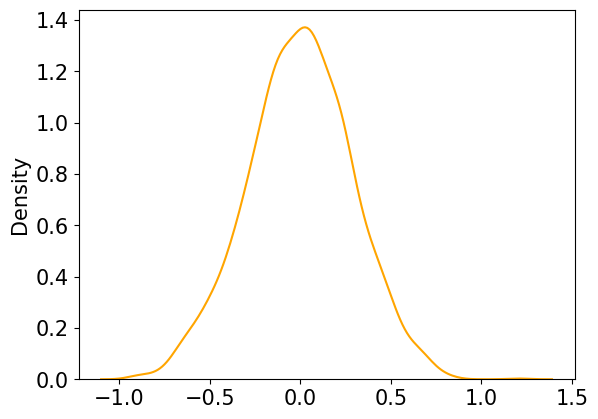

In [71]:
gene1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['gene'].numpy())
plot_node_feat(gene1_df)

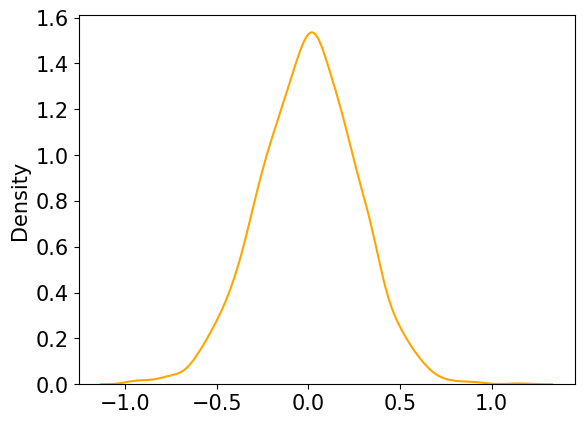

In [72]:
gene2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['gene'].numpy())
plot_node_feat(gene2_df)

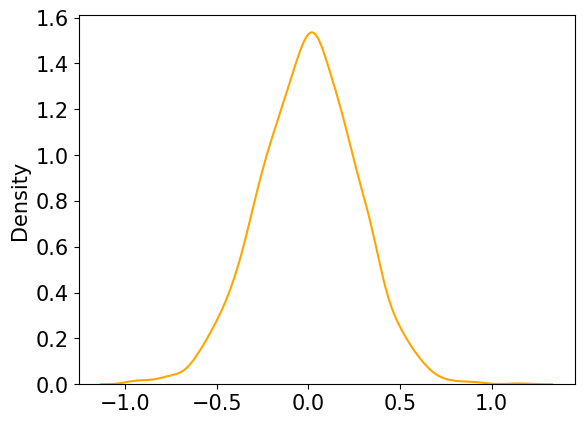

In [73]:
gene3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['gene'].numpy())
plot_node_feat(gene3_df)

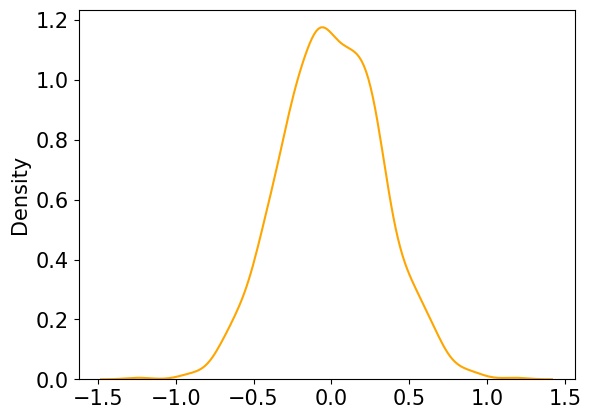

In [74]:
gene4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['gene'].numpy())
plot_node_feat(gene4_df)

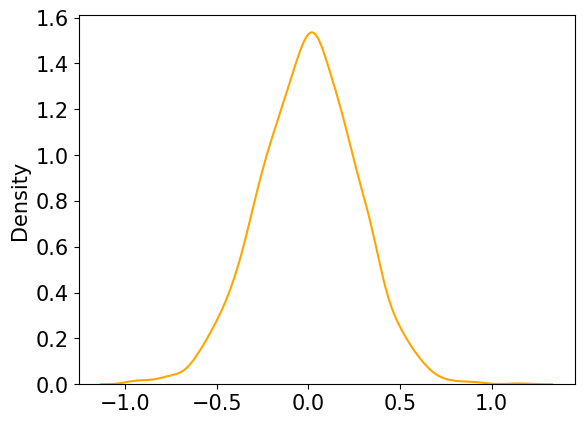

In [75]:
gene5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['gene'].numpy())
plot_node_feat(gene5_df)

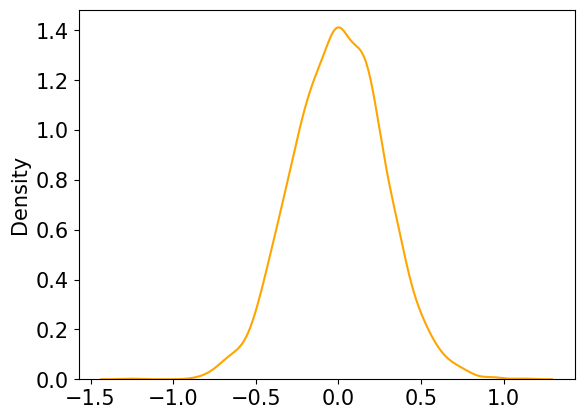

In [76]:
gene6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['gene'].numpy())
plot_node_feat(gene6_df)

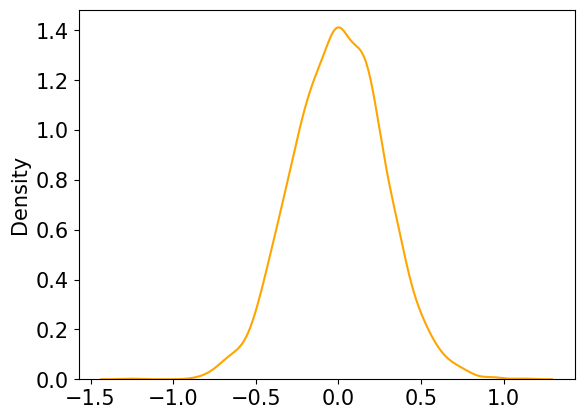

In [77]:
gene7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['gene'].numpy())
plot_node_feat(gene7_df)

In [78]:
#Chemical

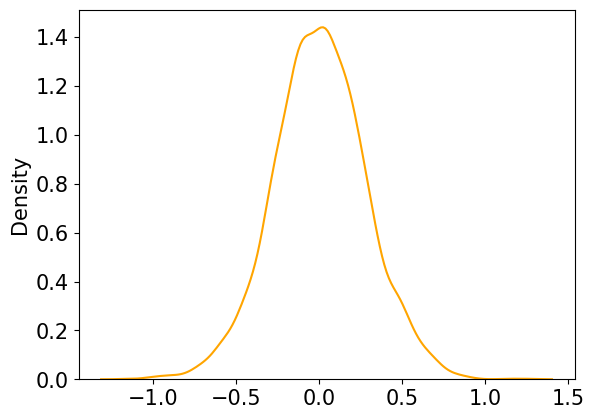

In [79]:
chemical0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['chemical'].numpy())
plot_node_feat(chemical0_df)

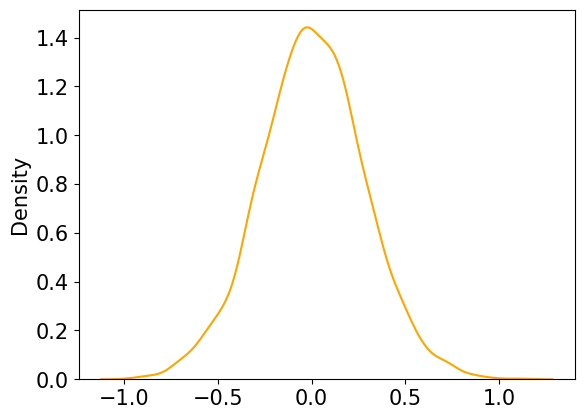

In [80]:
chemical1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['chemical'].numpy())
plot_node_feat(chemical1_df)

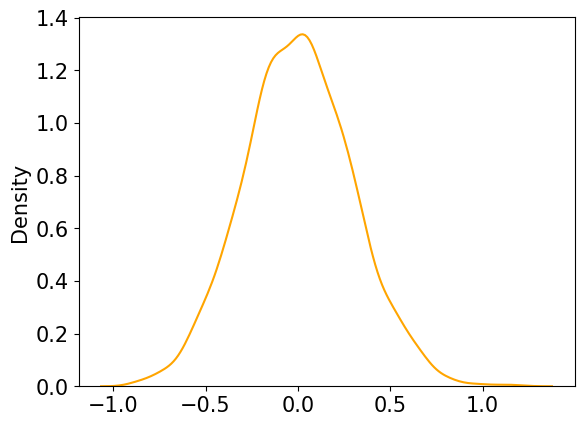

In [81]:
chemical2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['chemical'].numpy())
plot_node_feat(chemical2_df)

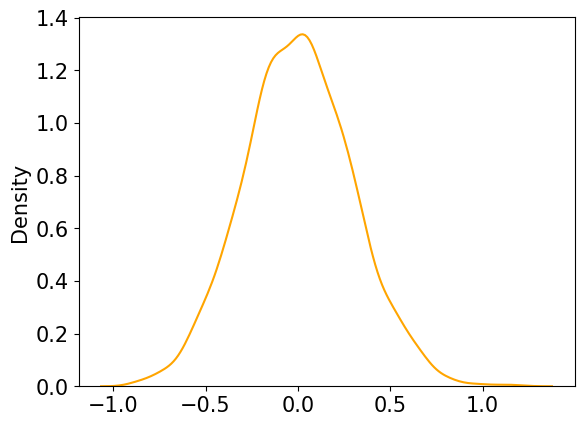

In [82]:
chemical3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['chemical'].numpy())
plot_node_feat(chemical3_df)

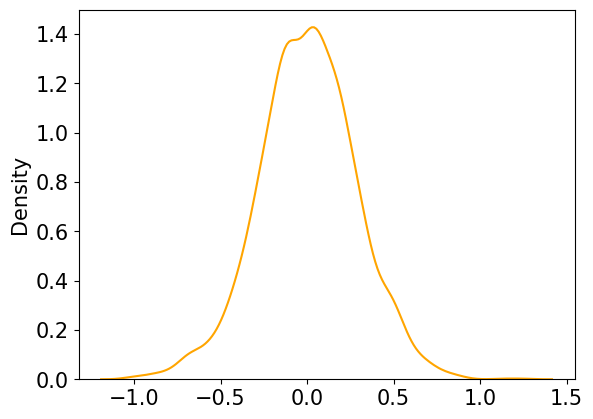

In [83]:
chemical4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['chemical'].numpy())
plot_node_feat(chemical4_df)

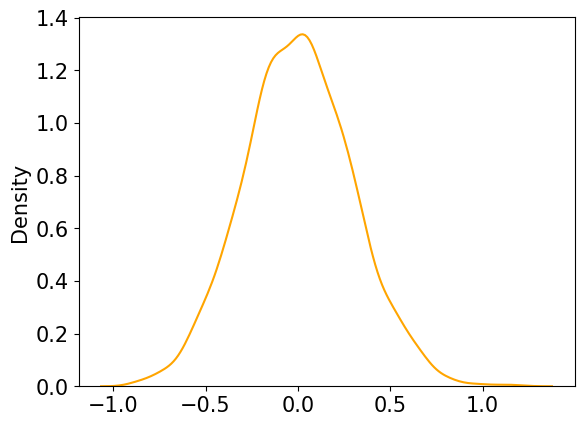

In [84]:
chemical5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['chemical'].numpy())
plot_node_feat(chemical5_df)

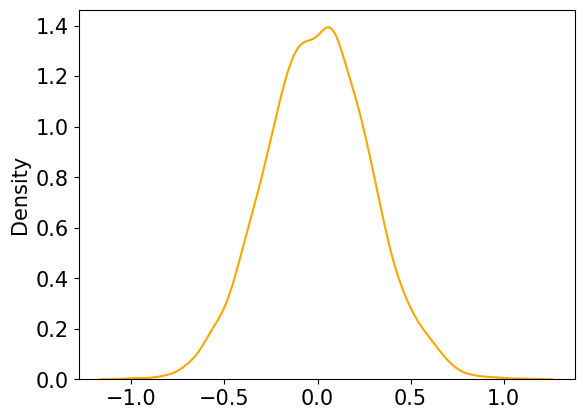

In [85]:
chemical6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['chemical'].numpy())
plot_node_feat(chemical6_df)

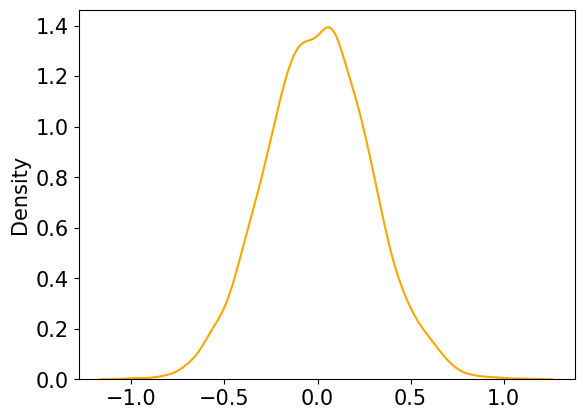

In [86]:
chemical7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['chemical'].numpy())
plot_node_feat(chemical7_df)

In [87]:
#Species

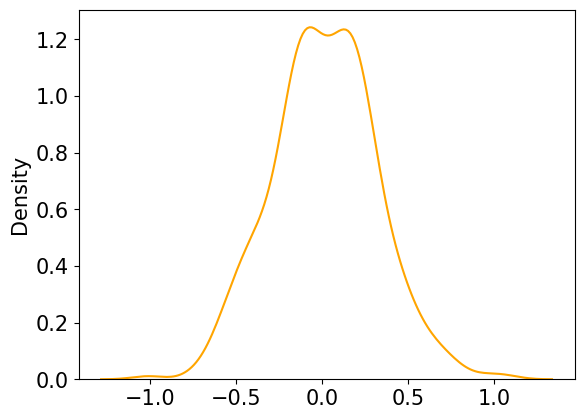

In [88]:
species0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['species'].numpy())
plot_node_feat(species0_df)

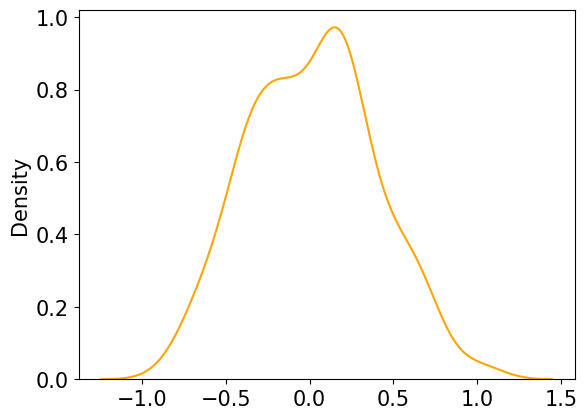

In [89]:
species1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['species'].numpy())
plot_node_feat(species1_df)

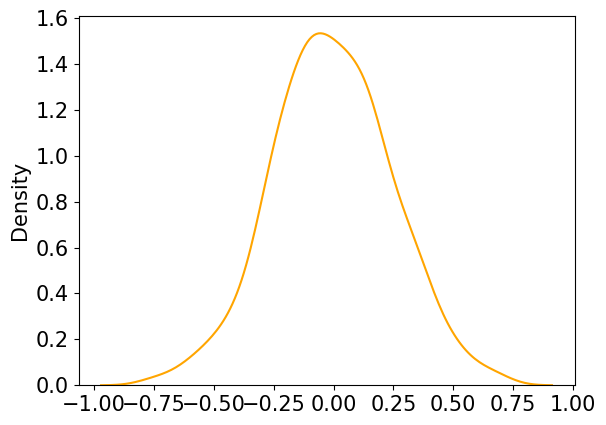

In [90]:
species2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['species'].numpy())
plot_node_feat(species2_df)

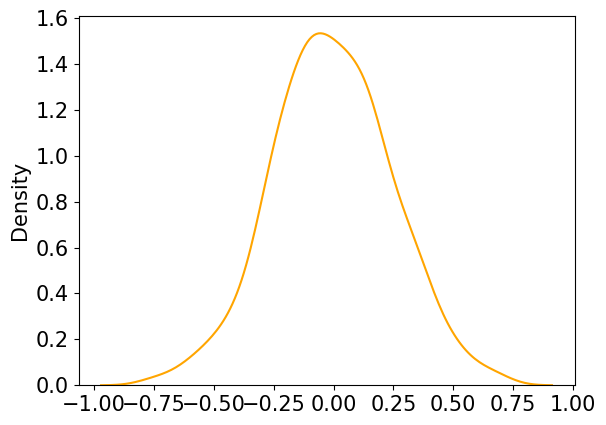

In [91]:
species3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['species'].numpy())
plot_node_feat(species3_df)

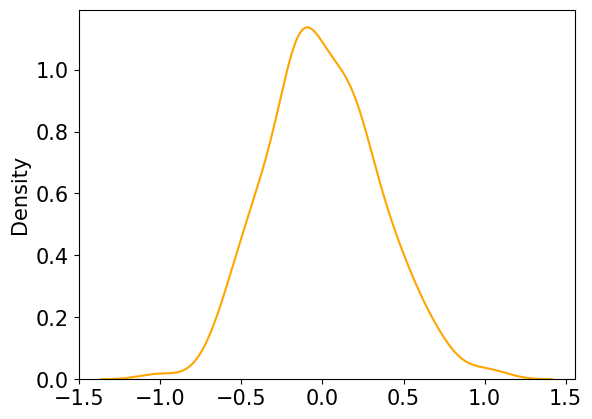

In [92]:
species4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['species'].numpy())
plot_node_feat(species4_df)

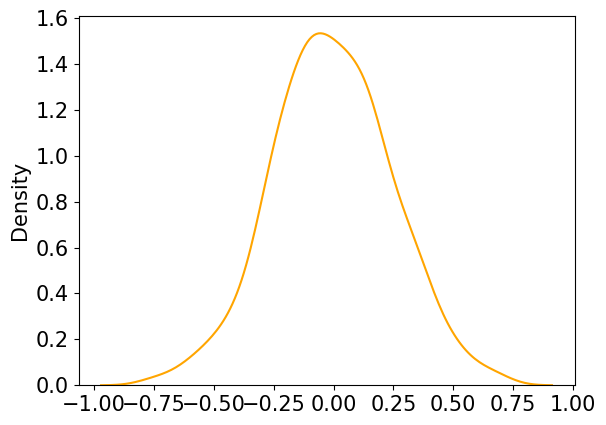

In [93]:
species5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['species'].numpy())
plot_node_feat(species5_df)

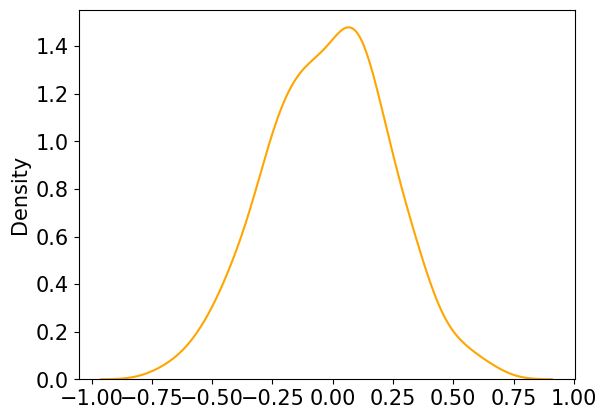

In [94]:
species6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['species'].numpy())
plot_node_feat(species6_df)

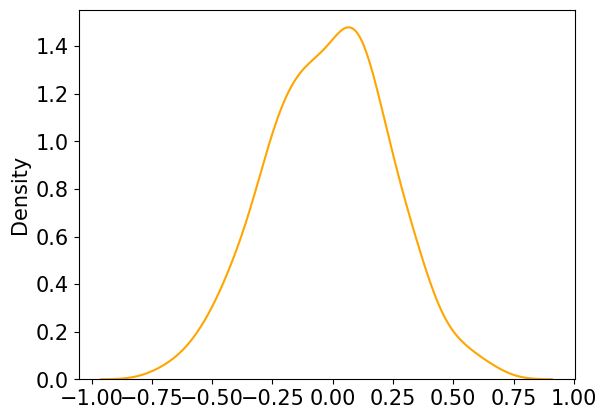

In [95]:
species7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['species'].numpy())
plot_node_feat(species7_df)